In [79]:
import pandas
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import metrics
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn import model_selection
from sklearn import linear_model as lm
from sklearn import preprocessing
from sklearn import pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegressionCV
from sklearn import neighbors
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn import ensemble
from sklearn import tree
import pickle
from sklearn import decomposition


pandas.set_option("display.precision", 2)

input_table = '../../Data/Raw/dogs.parquet'

model_score_file = '../../Data/Modeling/model_scores.parquet'
model_file = '../../Data/Modeling/trained_models.jbl'
save_data =  '../../Data/Modeling/dev_results.jbl'
class_file = '../../Data/Modeling/classes.jbl'


target_variable = ['breed']

# Carga dos Dados

In [80]:
data = pandas.read_parquet(input_table)
print('data shape:', data.shape)

data shape: (521, 4097)


# Treino / Teste

In [81]:
X = data.drop(target_variable, axis = 1).values
Y = data[target_variable].values

In [82]:
classifier_variables = data.drop(target_variable, axis = 1).keys

In [83]:
classes = data.breed.unique()
classes

array(['affenpinscher', 'african', 'airedale'], dtype=object)

In [84]:
Xtrain, Xtest, Ytrain, Ytest = model_selection.train_test_split(X,
                                                                Y,
                                                                test_size=0.2,
                                                                random_state=0,
                                                                stratify=Y)

# Objeto de validacao cruzada
cvfold = model_selection.StratifiedKFold(n_splits = 3)

# Construção do Pipeline

In [85]:
# Configure Pipeline
model_dict = {
    'RandomForest': ensemble.RandomForestClassifier(),
    'LogisticRegr': LogisticRegression(),
    'kNN': KNeighborsClassifier(weights='distance'),
    'SVM': SVC(probability=True, gamma='auto'),
}

model_conf = {
    'RandomForest': {
        'Model__n_estimators': [10, 30, 40],
        'Model__max_depth': [4, 6, 8],
    },
    'LogisticRegr': {
        'Model__C': [0.001, 0.1, 1, 10],
    },
    'kNN': {
        'Model__n_neighbors': [5, 10, 20],
    },
    'SVM': {
        'Model__kernel': ['rbf','poly'],
        'Model__C' : [0.1, 1, 10],
    }
}

#scorer = metrics.make_scorer(metrics.f1_score(average='micro'))

model_list = {}


for model_name in model_dict.keys():
    conf_train_pipe = [
        ('Scaler', StandardScaler()),
        ('PCA', decomposition.PCA(n_components=20)),
        ('Model', model_dict[model_name]),
    ]
    
    # Create Pipeline
    model_pipe = pipeline.Pipeline(conf_train_pipe)
    param_grid = model_conf[model_name].copy()
    model_pipe = model_selection.GridSearchCV(model_pipe, param_grid,
                                              scoring=None,
                                              cv=cvfold,
                                              return_train_score=True,)

    model_pipe.fit(Xtrain, Ytrain.ravel())
    model_list[model_name] = model_pipe 

# Acuracia dos modelos

In [86]:
for model_name in model_dict.keys():
    model = model_list[model_name]
    # estimate Y
    preds = model.predict(Xtest)
    print("Model:", model_name)
    print("Accuracy:", metrics.accuracy_score(Ytest,preds))

Model: RandomForest
Accuracy: 0.6
Model: LogisticRegr
Accuracy: 0.5619047619047619
Model: kNN
Accuracy: 0.6
Model: SVM
Accuracy: 0.5142857142857142


In [87]:
print("Accuray on train data")
for model_name in model_dict.keys():
    model = model_list[model_name]
    # estimate Y
    preds = model.predict(Xtrain)
    print("Model:", model_name)
    print("Accuracy:", metrics.accuracy_score(Ytrain,preds))

Accuray on train data
Model: RandomForest
Accuracy: 0.9879807692307693
Model: LogisticRegr
Accuracy: 0.5769230769230769
Model: kNN
Accuracy: 1.0
Model: SVM
Accuracy: 1.0


# Curva ROC

In [88]:
def plot_multiclass_roc(model_name, clf, X_test, y_test, n_classes, figsize=(17, 6)):
    y_score = clf.predict_proba(X_test)

    # structures
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    # calculate dummies once
    y_test_dummies = pandas.get_dummies(y_test.ravel(), drop_first=False).values
    for i in range(n_classes):
        fpr[i], tpr[i], _ = metrics.roc_curve(y_test_dummies[:, i], y_score[:, i])
        roc_auc[i] = metrics.auc(fpr[i], tpr[i])

    # roc for each class
    fig, ax = plt.subplots(figsize=figsize)
    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(model_name)
    for i in range(n_classes):
        ax.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f) for label %s' % (roc_auc[i], classes[i]))
    ax.legend(loc="best")
    ax.grid(alpha=.4)
    sns.despine()
    plt.show()

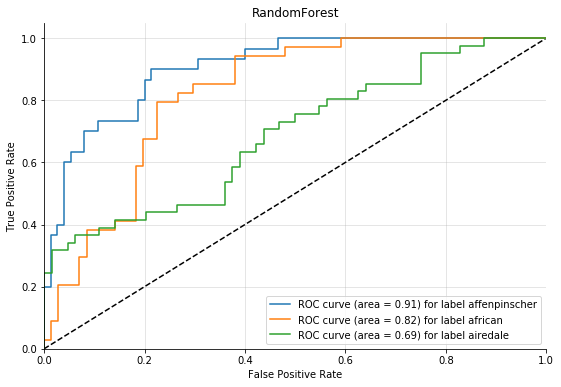

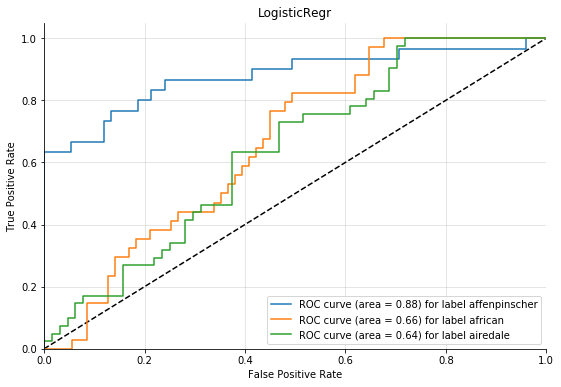

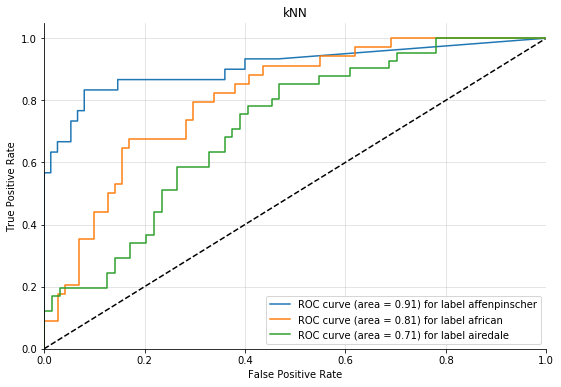

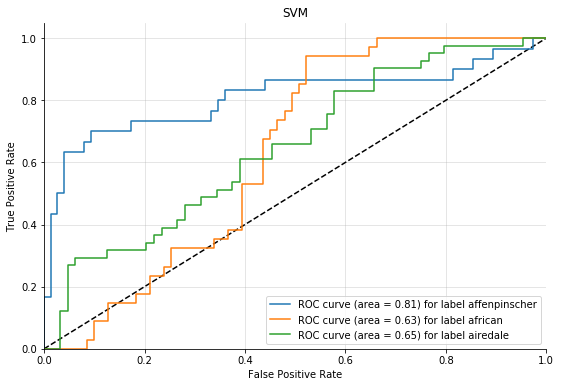

In [89]:
n_classes = len(classes)
for model_name in model_dict.keys():
    model = model_list[model_name]
    plot_multiclass_roc(model_name, model, Xtest, Ytest, n_classes, figsize=(9, 6))

## Matriz de confusão

In [93]:
for model_name in model_dict.keys():
    model = model_list[model_name]
    # estimate Y
    Ypred = model.predict(Xtest)
    col_names = ['Model ' + s for s in classes]
    idx_names = ['Real ' + s for s in classes]

    cmat = metrics.confusion_matrix(Ytest, Ypred)
    cmat = pandas.DataFrame(cmat, index=idx_names,
                              columns=col_names)
#    cmat['Real Total'] = cmat.sum(axis=1)
    cmat.loc['Model Total',:] = cmat.sum(axis=0)
    cmat = cmat.astype(int)
    print (model_name)
    print(cmat)
    print (metrics.classification_report(Ytest, Ypred))
    print()
    

RandomForest
                    Model affenpinscher  Model african  Model airedale
Real affenpinscher                   21              4               5
Real african                          0             21              13
Real airedale                         6             14              21
Model Total                          27             39              39
               precision    recall  f1-score   support

affenpinscher       0.78      0.70      0.74        30
      african       0.54      0.62      0.58        34
     airedale       0.54      0.51      0.53        41

     accuracy                           0.60       105
    macro avg       0.62      0.61      0.61       105
 weighted avg       0.61      0.60      0.60       105


LogisticRegr
                    Model affenpinscher  Model african  Model airedale
Real affenpinscher                   22              7               1
Real african                          2             12              20
Real airedale    

# Melhores parâmetros

In [91]:
for model_name in model_dict.keys():
    model = model_list[model_name]
    print(model.best_estimator_.steps[2])

('Model', RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=8, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=40,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False))
('Model', LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False))
('Model', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metri

# Distribuição

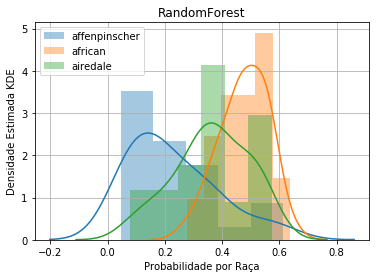

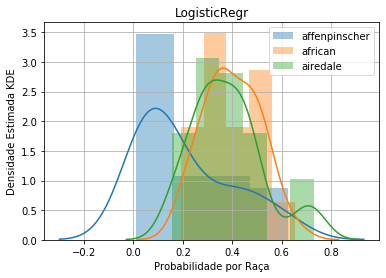

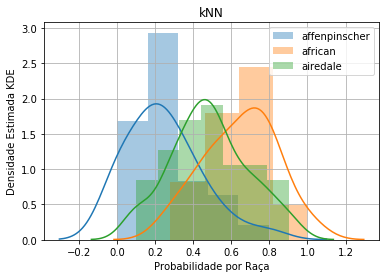

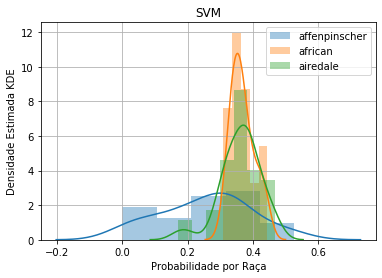

In [92]:
for model_name in model_dict.keys():
    model = model_list[model_name]
    # estimate Y
    Yhat = model.predict_proba(Xtest)[:,1]

    for i in range(len(classes)):
        # multiclass case
        sns.distplot(Yhat[Ytest[:,0] == classes[i]], label=classes[i])

    plt.title(model_name)
    plt.ylabel('Densidade Estimada KDE')
    plt.xlabel('Probabilidade por Raça')
    plt.grid()
    plt.legend()
    plt.show()